<img src="https://raw.githubusercontent.com/Qiskit/qiskit-tutorials/master/images/qiskit-heading.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Qubit Spectroscopy*_ 


***
### Contributors
Naoki Kanazawa

## Introduction

In this tutorial, we learn how to conduct qubit spectroscopy using OpenPulse. The OpenPulse frontend enables us to control qubits at the level of microwave pulses, and allows for controlling their driving frequency as well. This increases the degree of freedom in controlling quantum state. Qubit "chevron" pattern may be a good example of showing the capability of OpenPulse, in which we measure qubit Rabi oscillation for various microwave frequencies. As the frequency detuning increases, it is expected to observe faster oscillations with reduced excited state population.


**Contents**

[Qubit Spectroscopy](#sect1)


### References
[1] David C. McKay *et al.*, Qiskit Backend Specifications for OpenQASM and OpenPulse Experiments. https://arxiv.org/abs/1809.03452

Code imports
==============

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ, pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble

# Qubit Spectroscopy

In this tutorial, we use a quantum computing system with `open_pulse` enabled and `meas_level=2` is activated. We measure Rabi oscillation for various frequency detunings $\Delta f_i \in $ `freq_bounds`. At each driving frequency $f_d = f_q + \Delta f_i$, where $f_q$ is the dressed frequency of qubit, we measure the excited state population of target `qubit` after irradiation of driving pulses with different pulse duration $T \in $ `duration_bounds`.

You can refer to [qiskit iqx tutorials](https://github.com/Qiskit/qiskit-iqx-tutorials) for the details about creation of pulse `Schedule`.

In [2]:
# Target qubit
qubit = 0

# Number of experiments
num_duration = 31
num_drive_freq = 21

# Range of frequency detuning sweep in GHz
freq_bounds = -0.01, 0.01

# Range of duration sweep in the unit of dt
duration_bounds = 30, 300

# Rabi pulse spec
drive_amplitude = 0.02
drive_sigma = 3
drive_risefall = 12

# Number of shot
rabi_shots = 512

### Loading backend.

In [3]:
IBMQ.load_account()
ibmq_provider = IBMQ.get_provider(
    hub='provide_your_hub_name_here',
    group='provide_your_group_name_here',
    project='provide_your_project_name_here'
)
backend = ibmq_provider.get_backend(
    'ibmq_poughkeepsie'
)

In [4]:
system = pulse.PulseChannelSpec.from_backend(backend)

config = backend.configuration()
defaults = backend.defaults()

In [5]:
cmd_def = pulse.CmdDef.from_defaults(defaults.cmd_def, defaults.pulse_library)

measure = cmd_def.get('measure', qubits=config.meas_map[0])

### Creating pulse `Schedule`.

Each `Schedule` comprises a Rabi pulse with different pulse duration followed by measurement pulse and acquisition. These `Schedule`s are used for all driving frequencies.

In [6]:
# Frequency sweep centered at resonance frequency
df_lb, df_ub = freq_bounds
f_reso = defaults.qubit_freq_est[qubit]
freqs = np.linspace(f_reso + df_lb, f_reso + df_ub, num_drive_freq, dtype=float)

# Time sweep
duration_lb, duration_ub = duration_bounds
durations = np.linspace(duration_lb, duration_ub, num_duration, dtype=int)

In [7]:
schedules = []
for duration in durations:
    rabi_pulse = pulse_lib.gaussian_square(duration=duration,
                                           amp=drive_amplitude,
                                           sigma=drive_sigma,
                                           risefall=drive_risefall,
                                           name = 'drive_t_%d' % duration)

    schedule = pulse.Schedule(name='duration_%3d' % duration)
    schedule = schedule | rabi_pulse(system.qubits[qubit].drive)
    schedule = schedule | measure << schedule.duration + defaults.buffer

    schedules.append(schedule)

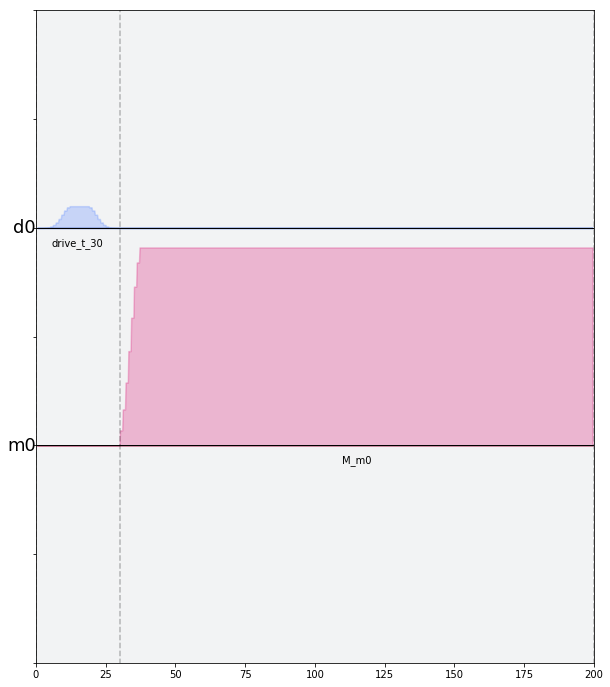

In [8]:
schedules[0].draw(channels_to_plot=[system.qubits[0].drive, system.qubits[0].measure], label=True, plot_range=(0, 200), scaling=10)

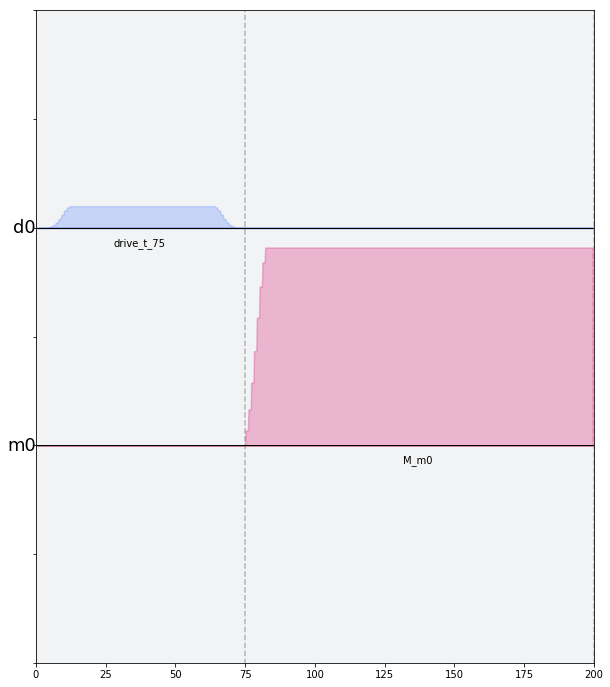

In [9]:
schedules[5].draw(channels_to_plot=[system.qubits[0].drive, system.qubits[0].measure], label=True, plot_range=(0, 200), scaling=10)

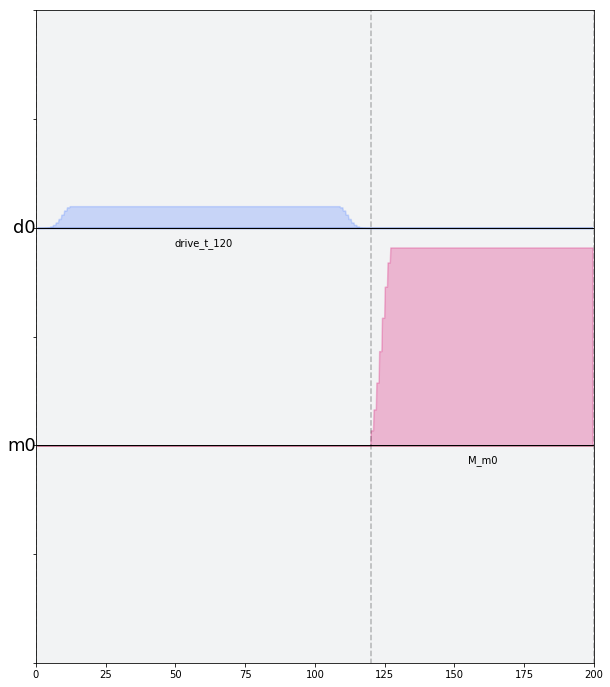

In [10]:
schedules[10].draw(channels_to_plot=[system.qubits[0].drive, system.qubits[0].measure], label=True, plot_range=(0, 200), scaling=10)

### Creating `PulseQobj`s.
Qobj is created for each driving frequency. Each qobj comprises several `Schedule`s for pulse duration sweep.

In [11]:
qobj_freq_sweeps = []
for freq in freqs:
    lo_settings = defaults.qubit_freq_est.copy()
    lo_settings[qubit] = freq
    
    qobj_freq_sweeps.append(assemble(schedules, backend,
                                     meas_level=2,
                                     meas_return='single',
                                     shots=rabi_shots,
                                     qubit_lo_freq=lo_settings))

Warning: this sends a lot of jobs
=======

Uncomment the below cell to run the experiment. Make sure your token has enough capability to run these jobs.

In [10]:
# jobs = []
# for qobj in qobj_freq_sweeps:
#     jobs.append(backend.run(qobj))

In [17]:
for job, freq in zip(jobs, freqs):
    print('%f GHz || job_id="%s"' % (freq, job.job_id()))

5.036901 GHz || job_id="5d6e8d65750f40001950b72c"
5.037901 GHz || job_id="5d6e8d67a022f60018990b7e"
5.038901 GHz || job_id="5d6e8d6d750f40001950b72e"
5.039901 GHz || job_id="5d6e8d6f017bdb0019330055"
5.040901 GHz || job_id="5d6e8d69a022f60018990b80"
5.041901 GHz || job_id="5d6e8d6b017bdb0019330053"
5.042901 GHz || job_id="5d6e8d6da022f60018990b82"
5.043901 GHz || job_id="5d6e8d6d61b82a0019a82c75"
5.044901 GHz || job_id="5d6e8d73750f40001950b730"
5.045901 GHz || job_id="5d6e8d7019f20e00187493e2"
5.046901 GHz || job_id="5d6e8d719dbedc0018dd21c6"
5.047901 GHz || job_id="5d6e8d749dbedc0018dd21c8"
5.048901 GHz || job_id="5d6e8d7319f20e00187493e4"
5.049901 GHz || job_id="5d6e8d75747e970019d4e802"
5.050901 GHz || job_id="5d6e8d76a022f60018990b84"
5.051901 GHz || job_id="5d6e8d78a022f60018990b86"
5.052901 GHz || job_id="5d6e8d79017bdb0019330057"
5.053901 GHz || job_id="5d6e8d7a750f40001950b732"
5.054901 GHz || job_id="5d6e8d7b017bdb0019330059"
5.055901 GHz || job_id="5d6e8d7d017bdb001933005b"


In [18]:
for job in jobs:
    print(job.status())

JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE
JobStatus.DONE


### Analyze the results.

In [19]:
results = [job.result() for job in jobs]

In [21]:
chevron_data = np.zeros((num_duration, num_drive_freq))

for ind_freq in range(num_drive_freq):
    for ind_duration in range(num_duration):
        counts = results[ind_freq].get_counts('duration_%3d' % durations[ind_duration])
        excited_pop = 0
        for bits, count in counts.items():
            excited_pop += count if bits[::-1][qubit] == '1' else 0
        chevron_data[ind_duration, ind_freq] = excited_pop/rabi_shots

Text(0.5, 1.0, 'Qubit 0')

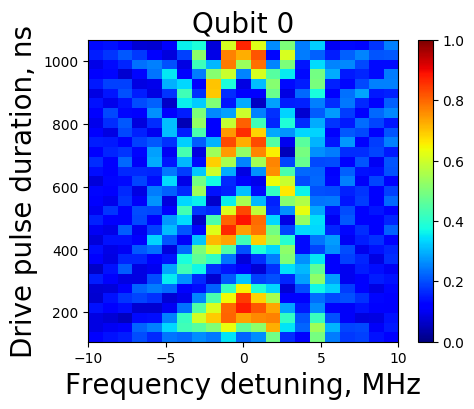

In [27]:
min_freq = freq_bounds[0] * 1e3
max_freq = freq_bounds[1] * 1e3

min_time = duration_bounds[0] * config.dt
max_time = duration_bounds[1] * config.dt

plt.figure(figsize=(5, 4), dpi=100)

plt.imshow(chevron_data,
           extent=[min_freq, max_freq, min_time, max_time],
           cmap='jet',
           origin='lowest', aspect='auto', vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('Frequency detuning, MHz', fontsize=20)
plt.ylabel('Drive pulse duration, ns', fontsize=20)
plt.title('Qubit %s' % qubit, fontsize=20)

When we cut a cross section at certain pulse duration $T$, we can observe a peak centered at backend default frequency `qubit_freq_est`. The dashed line corresponds to this calibrated frequency.

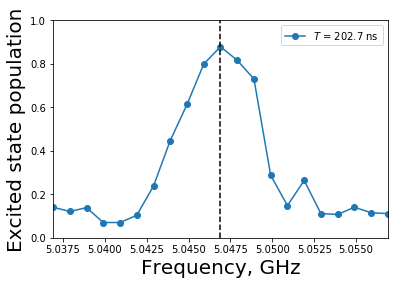

In [64]:
plt.plot(freqs, chevron_data[3, :], marker="o", label='$T$ = %.1f ns' % (durations[3] * config.dt))
plt.axvline(defaults.qubit_freq_est[qubit], color='black', linestyle='dashed')
plt.xlim(freqs[0], freqs[-1])
plt.ylim(0, 1)
plt.xlabel('Frequency, GHz', fontsize=20)
plt.ylabel('Excited state population', fontsize=20)
plt.legend()